# VGG From Scratch

Start with imports:

In [1]:
import numpy as np
from numpy.random import random, permutation
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.models import Sequential, Model
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers import Input
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.optimizers import SGD, RMSprop
from keras.preprocessing import image

import json

Using Theano backend.


## Classes
Start by examining imagenet classes, as pulled from fast.ai:

In [2]:
# Load and cache using keras' get_file
FILES_PATH = 'http://files.fast.ai/models/'; CLASS_FILE='imagenet_class_index.json'
fpath = get_file(CLASS_FILE, FILES_PATH+CLASS_FILE, cache_subdir='models')
with open(fpath) as f: 
    class_dict = json.load(f)

# Convert dict to array
classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

In [3]:
print(classes[:20])

['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead', 'electric_ray', 'stingray', 'cock', 'hen', 'ostrich', 'brambling', 'goldfinch', 'house_finch', 'junco', 'indigo_bunting', 'robin', 'bulbul', 'jay', 'magpie', 'chickadee']


## Model

Now build the model, starting with defining the blocks.

### Blocks

Convolutional and Fully Connected Building Blocks:

In [4]:
def ConvBlock(layers, model, filters):
    for i in range(layers):
        model.add(ZeroPadding2D((1,1)))
        model.add(Convolution2D(filters, (3,3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

In [5]:
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

### Architecture

Replicate the normalization function from original vgg paper, then build the model!

In [6]:
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean
    return x[:, ::-1] # bgr -> rgb

In [9]:
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3, 224, 224), output_shape=(3, 224, 224)))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    ConvBlock(3, model, 512)
    
    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(1000, activation='softmax'))
    
    return model

In [10]:
model = VGG_16()

### Load Pretrained Weights

In [11]:
fpath = get_file('vgg16.h5', FILES_PATH+'vgg16.h5', cache_subdir='models')
model.load_weights(fpath)

## Predict!

In [12]:
batch_size = 4

In [16]:
path = "../../../data/dogscats/sample/"
def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=batch_size, class_mode="categorical"):
    return gen.flow_from_directory(path+dirname, target_size=(224, 224), class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

In [17]:
batches = get_batches('train', batch_size=batch_size)
val_batches = get_batches('valid', batch_size=batch_size)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.


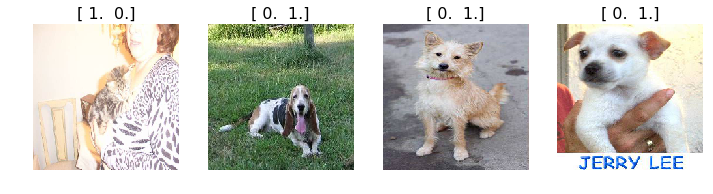

In [35]:
imgs, labels = next(batches)

from importlib import reload
import utils; reload(utils)
from utils import plots
%matplotlib inline
plots(imgs, titles=labels)

In [36]:
def pred_batch(imgs):
    preds = model.predict(imgs)
    idxs = np.argmax(preds, axis=1)
    
    print("Shape: {}".format(preds.shape))
    print("First 5 classes: {}".format(classes[:5]))
    print("First 5 probabilities: {}".format(preds[:5]))
    print("Predictions prob/class:")
    
    for i in range(len(idxs)):
        idx=idxs[i]
        print ('  {:.4f}/{}'.format(preds[i, idx], classes[idx]))

In [37]:
pred_batch(imgs)

Shape: (4, 1000)
First 5 classes: ['tench', 'goldfish', 'great_white_shark', 'tiger_shark', 'hammerhead']
First 5 probabilities: [[  2.7337e-06   1.7431e-06   6.7354e-06 ...,   2.2260e-06   4.5700e-06   6.2611e-04]
 [  1.7528e-09   2.7648e-10   6.5126e-09 ...,   4.3670e-08   5.5755e-08   1.6313e-07]
 [  3.5403e-06   6.3690e-05   2.0218e-06 ...,   2.5561e-06   2.7229e-04   8.1361e-04]
 [  1.4613e-08   5.1535e-08   1.9935e-08 ...,   2.5205e-08   4.8988e-07   1.0764e-05]]
Predictions prob/class:
  0.5450/pajama
  0.9585/basset
  0.3335/Norwich_terrier
  0.9872/Chihuahua
